## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was to rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

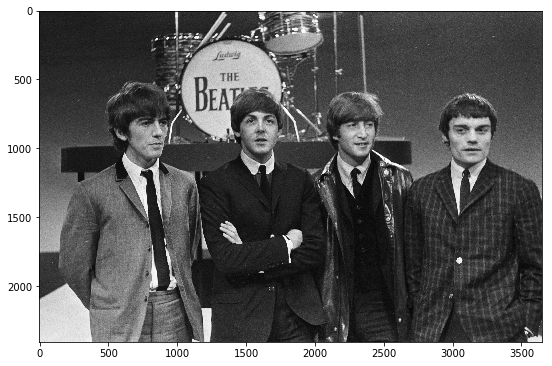

In [17]:
import cv2
# load in color image for face detection
image_1 = cv2.imread('images/obamas.jpg')
image_2 = cv2.imread('images/mona_lisa.jpg')
image_3 = cv2.imread('images/the_beatles.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2RGB)

images = [image_1, image_2, image_3]

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(images[2])

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


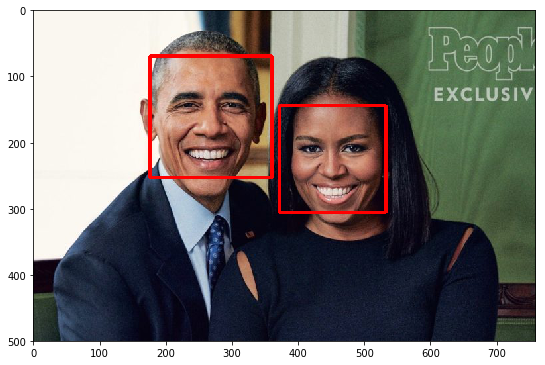

In [18]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')


# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image

faces_list = []
images_with_detections = []
# make a copy of the original image to plot detections on
for image in images:
    faces_list.append(face_cascade.detectMultiScale(image, 1.3, 5))
    images_with_detections.append(image.copy())

for i, faces in enumerate(faces_list):
    # loop over the detected faces, mark the image where each face is found
    
    rec_thickness = images_with_detections[i].shape[0]//150
    for (x,y,w,h) in faces:
        # draw a rectangle around each detected face
        # you may also need to change the width of the rectangle drawn depending on image resolution
        cv2.rectangle(images_with_detections[i],(x,y),(x+w,y+h),(255,0,0),rec_thickness) 
        
fig = plt.figure(figsize=(9,9))

plt.imshow(images_with_detections[0])

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [52]:
import torch
from models import Net
import torch.nn as nn

net = Net()


## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load('./Facial_keypoints_detector.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (resnet18): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

**Hint**: The sizes of faces detected by a Haar detector and the faces your network has been trained on are of different sizes. If you find that your model is generating keypoints that are too small for a given face, try adding some padding to the detected `roi` before giving it as input to your model.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




In [53]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    #image = np.pad(image,(15,10),mode='constant')
    plt.imshow(image, cmap='gray')
# undo normalization of keypoints  
   # print(predicted_key_pts[:,:,0])
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

In [54]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
#visualize_output(test_images, test_outputs, gt_pts)

In [74]:
img_size = 224
def detect_keypoints(image_nr, scale, net):
    fig = plt.figure(figsize=(10,10))
    i = 0
    image_copy = np.copy(images[image_nr])
    # loop over the detected faces from your haar cascade
    for (x,y,w,h) in faces_list[image_nr]:
    
        # Select the region of interest that is the face in the image 
        roi = image_copy[y-scale:y+h+scale, x-scale:x+w+scale]
        
        ## Convert the face region from RGB to grayscale
        roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
        ## Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
        roi = roi/255.0
        ## Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
        h, w = roi.shape
                
        roi = cv2.resize(roi, (img_size, img_size))
        
        # Make copy for displaying keypoint over
        roi_copy = np.copy(roi)
        
        ## Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
        
        # if image has no grayscale color channel, add one
        if(len(roi.shape) == 2):
            # add that third color dim
            roi = roi.reshape(roi.shape[0], roi.shape[1], 1)
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        roi = roi.transpose((2, 0, 1))
        
        roi = torch.from_numpy(roi)
        roi = roi.type(torch.FloatTensor)
        
        roi.unsqueeze_(0)
        ## Make facial keypoint predictions using your loaded, trained network     
        ## perform a forward pass to get the predicted facial keypoints
        
        # forward pass to get net output
        output_pts = net(roi)
        # reshape to size x 68 x 2 pts
        output_pts = output_pts.view(68, -1)
        
        # undo normalization of keypoints
        output_pts = output_pts.detach().numpy()   
        output_pts = output_pts*(roi_copy.shape[0]/4)+roi_copy.shape[0]/2
        
        ## Display each detected face and the corresponding keypoints     
        fig.add_subplot(2, 2, i+1)
        plt.imshow(roi_copy, cmap='gray')
        plt.scatter(output_pts[:, 0], output_pts[:, 1], s=15, marker='.', c='m')
        plt.axis('off')
        i += 1
        
    plt.show()

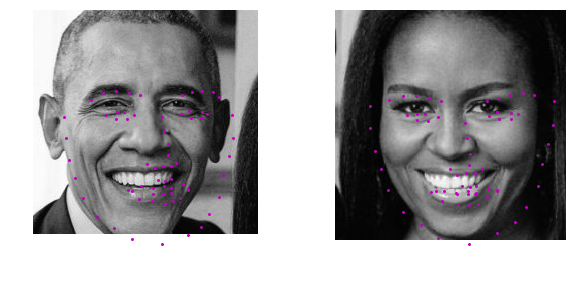

In [76]:
detect_keypoints(0,20,net)

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


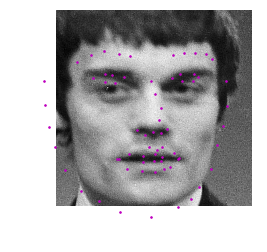

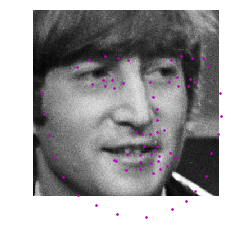

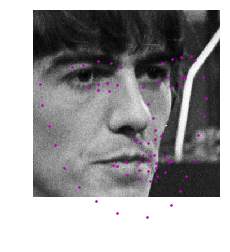

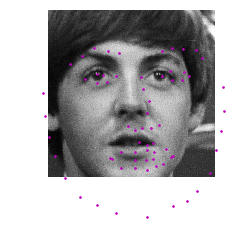

In [83]:

image_copy = np.copy(image)


i = 0 


# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces[::-1]:
    
    
    # Select the region of interest that is the face in the image 
    
    roi = image_copy[y:y+h, x:x+w]
    
    ## TODO: Convert the face region from RGB to grayscale
    
    roi = cv2.cvtColor(roi , cv2.COLOR_RGB2GRAY)
    

    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi / 255.0
    
    roi_copy = np.copy(roi)
 

    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)

    roi = cv2.resize(roi, (224, 224))


    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)


    if(len(roi.shape) == 2):
            # add that third color dim
            roi = roi.reshape(roi.shape[0], roi.shape[1], 1)
    roi = roi.transpose((2, 0, 1))
    roi = torch.from_numpy(roi)
    
    roi = roi.type(torch.FloatTensor)

    
    roi.unsqueeze_(0)

    ## TODO: Make facial keypoint predictions using your loaded, trained network 
    ## Un-Normalizing the points 
    

    op = net(roi)
    op = op.view(68, -1)

   
    # undo normalization of keypoints
    op = op.detach().numpy()   
    op = op*100 + 170


    fig.add_subplot(2, 2, i+1)
    plt.imshow(roi_copy, cmap='gray')
    plt.scatter(op[:, 0], op[:, 1], s=10, marker='.', c='m')
    plt.axis('off')
    i += 1
        
    plt.show()